# Mudanças climáticas: uma análise pythônica

In [1]:
%%HTML
<img src="earth_on_fire.jpg">

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import seaborn as sns
# import warnings
# warnings.filterwarnings('ignore')

global_temp_country = pd.read_csv('GlobalLandTemperaturesByCountry.csv')
cd = pd.read_csv("archive.csv")
df = pd.read_csv("GlobalLandTemperaturesByState.csv")
si = pd.read_csv("seaice.csv")

# Conhecendo os dados

In [3]:
def summary(df):
    # Identify the Data Types
    s_df = pd.DataFrame(df.dtypes, columns=['Dtype'])

    # Identify the unique values
    s_df['Nunique'] = df.nunique()

    # Identify the Missing values
    s_df['MissingValues'] = df.isnull().sum()

    # Identify the count for each variable
    s_df['Count'] = df.count()

    # Identify the zero values for each variable
    s_df['ZeroValues'] = (df == 0).sum()

    print(s_df)

In [4]:
# Temperatura media global
summary(global_temp_country)

                                 Dtype  Nunique  MissingValues   Count  \
dt                              object     3239              0  577462   
AverageTemperature             float64    76605          32651  544811   
AverageTemperatureUncertainty  float64     8979          31912  545550   
Country                         object      243              0  577462   

                               ZeroValues  
dt                                      0  
AverageTemperature                      7  
AverageTemperatureUncertainty           0  
Country                                 0  


In [5]:
# Temperatura por estado
summary(df)

                                 Dtype  Nunique  MissingValues   Count  \
dt                              object     3239              0  645675   
AverageTemperature             float64   100001          25648  620027   
AverageTemperatureUncertainty  float64     8040          25648  620027   
State                           object      241              0  645675   
Country                         object        7              0  645675   

                               ZeroValues  
dt                                      0  
AverageTemperature                     15  
AverageTemperatureUncertainty           0  
State                                   0  
Country                                 0  


In [6]:
# Dados de CO2
summary(cd)

                                     Dtype  Nunique  MissingValues  Count  \
Year                                 int64       60              0    720   
Month                                int64       12              0    720   
Decimal Date                       float64      720              0    720   
Carbon Dioxide (ppm)               float64      679             17    703   
Seasonally Adjusted CO2 (ppm)      float64      667             17    703   
Carbon Dioxide Fit (ppm)           float64      680             13    707   
Seasonally Adjusted CO2 Fit (ppm)  float64      707             13    707   

                                   ZeroValues  
Year                                        0  
Month                                       0  
Decimal Date                                0  
Carbon Dioxide (ppm)                        0  
Seasonally Adjusted CO2 (ppm)               0  
Carbon Dioxide Fit (ppm)                    0  
Seasonally Adjusted CO2 Fit (ppm)           0  

In [7]:
# Dados de extensao de calotas polares
summary(si)

               Dtype  Nunique  MissingValues  Count  ZeroValues
Year           int64       40              0  24908           0
Month          int64       12              0  24908           0
Day            int64       31              0  24908           0
Extent       float64    12714              0  24908           0
Missing      float64        3              0  24908       24901
Source Data   object    24908              0  24908           0
hemisphere    object        2              0  24908           0


# Mapeamento da temperatura média nos países

In [8]:
#Let's remove the duplicated countries (in the analysis, we don't consider the presence of 
#colonies at this the countries) and countries for which no information about the temperature

global_temp_country_clear = global_temp_country[~global_temp_country['Country'].isin(
    ['Denmark', 'Antarctica', 'France', 'Europe', 'Netherlands',
     'United Kingdom', 'Africa', 'South America'])]

global_temp_country_clear = global_temp_country_clear.replace(
   ['Denmark (Europe)', 'France (Europe)', 'Netherlands (Europe)', 'United Kingdom (Europe)'],
   ['Denmark', 'France', 'Netherlands', 'United Kingdom'])


#Let's average temperature for each country
countries = np.unique(global_temp_country_clear['Country'])
mean_temp = []
for country in countries:
    mean_temp.append(global_temp_country_clear[global_temp_country_clear['Country'] == 
                                               country]['AverageTemperature'].mean())


    
data = [ dict(
        type = 'choropleth',
        locations = countries,
        z = mean_temp,
        locationmode = 'country names',
        text = countries,
        marker = dict(
            line = dict(color = 'rgb(0,0,0)', width = 1)),
            colorbar = dict(autotick = True, tickprefix = '', 
            title = '# Average\nTemperature,\n°C')
            )
       ]

layout = dict(
    title = 'Average land temperature in countries',
    geo = dict(
        showframe = False,
        showocean = True,
        oceancolor = 'rgb(0,255,255)',
        projection = dict(
        type = 'orthographic',
            rotation = dict(
                    lon = 60,
                    lat = 10),
        ),
        lonaxis =  dict(
                showgrid = True,
                gridcolor = 'rgb(102, 102, 102)'
            ),
        lataxis = dict(
                showgrid = True,
                gridcolor = 'rgb(102, 102, 102)'
                )
            ),
        )

fig = dict(data=data, layout=layout)
py.iplot(fig, validate=False, filename='worldmap')

# Temperatura média no Brasil ao longo dos anos

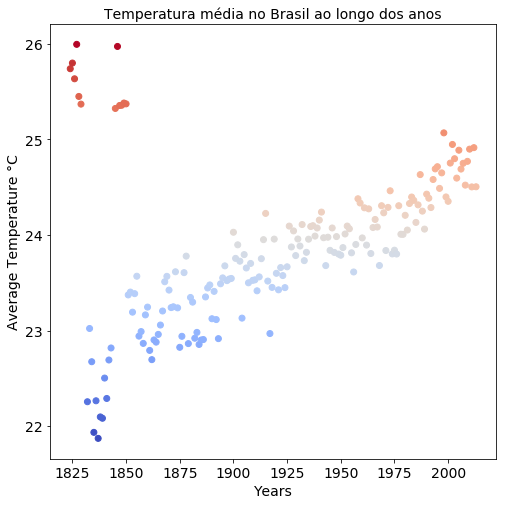

In [20]:
#clean up year
def to_year(date):
    """
    returns year from date time
    """
    for i in [date]:
        first = i.split('-')[0]
        return int(first)
 
df['Year'] = df['dt'].apply(to_year)

#select only data from Brazil
dfs = df[df['Country'] == 'Brazil']
# dfs = df

#calculate average temp per year
dfa = pd.DataFrame()
years = dfs['Year'].unique()
for year in years:
    df_avg = dfs[dfs['Year'] == year]['AverageTemperature'].mean()
    df_new = (dfs[dfs['Year'] == year]).head(1)
    df_new['AverageTemperature'] = df_avg
    dfa = dfa.append(df_new)

plt.figure(figsize=(8,8))
plt.title('Temperatura média no Brasil ao longo dos anos', fontsize=14)
plt.xlabel('Years', fontsize=14)
plt.ylabel('Average Temperature °C', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.scatter(x='Year', y='AverageTemperature', c = 'AverageTemperature', cmap= 'coolwarm', data=dfa)


# Manipulação de dados

In [10]:
#calculate average sea ice extent per year
sia = pd.DataFrame() #creates dataframe sia
years = si['Year'].unique() #creates list of unique years

for year in years:
    si_avg = si[si['Year'] == year]['Extent'].mean()  #calculate average sea ice extent for given year
    si_new = (si[si['Year'] == year]).head(1) #attribute year info to si_new
    si_new['Extent'] = si_avg #replace extent info with average extent info
    sia = sia.append(si_new) #append this informationsia = pd.DataFrame()

In [11]:
#average CO2 ppm per year
dfc = pd.DataFrame() #creates dataframe dfc
years = cd['Year'].unique() #creates list of unique years
for year in years:
    df_avg = cd[cd['Year'] == year]['Carbon Dioxide (ppm)'].mean() #calculate average carbon dioxide concentration for given year
    df_new = (cd[cd['Year'] == year]).head(1) #attribute year info to df_new
    df_new['Carbon Dioxide (ppm)'] = df_avg #replace carbon dioxide info with average carbon dioxide info
    dfc = dfc.append(df_new) #append this info

In [12]:
# merge CO2 data with temp and sea ice data
merge_co2 = pd.merge(dfa, dfc, on=['Year']) #merge dfa and dfc dataframes according to year
dfcss = pd.merge(merge_co2, sia, on=['Year']) #merge the created dataframe with the sia dataframe

#drop unwanted columns
dfcss.drop(['Seasonally Adjusted CO2 (ppm)', 'Carbon Dioxide Fit (ppm)', 'Seasonally Adjusted CO2 Fit (ppm)', 'Decimal Date', 'Month_x', 'Month_y', 'Day', 'Missing', ], inplace=True, axis=1)

# Concentração de CO2 ao longo dos anos

In [13]:
%%HTML
<center><img src="Carbon-Pollution.jpg"></center>

Text(0.5,1,'Carbon dioxide vs years')

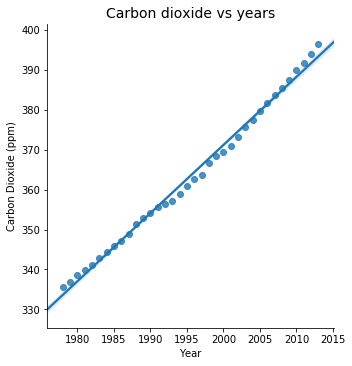

In [14]:
# Linear regression CO2 vs year
sns.lmplot(x='Year', y='Carbon Dioxide (ppm)', data=dfcss) #plots data in a regression model
ax = plt.gca() #gets argument names for axis
ax.set_title("Carbon dioxide vs years", fontsize=14) #sets title

Text(0.5,1,'Carbon Dioxide vs Average Temperature')

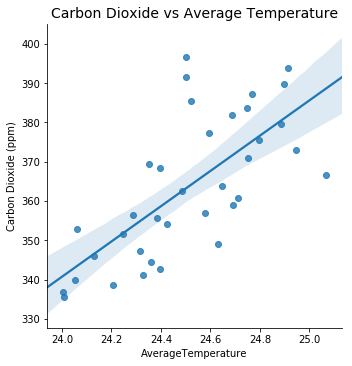

In [15]:
# Linear regression Co2 vs average temperature (Brazil)
sns.lmplot(x='AverageTemperature', y='Carbon Dioxide (ppm)', data =dfcss) #plots data in a regression model
ax = plt.gca()  #gets argument names for axis
ax.set_title("Carbon Dioxide vs Average Temperature", fontsize=14) #sets title

# Extensão das calotas polares

In [16]:
%%HTML
<center><img src="polar_bear.jpg"></center>

Text(0.5,1,'Sea Ice Extent vs Time')

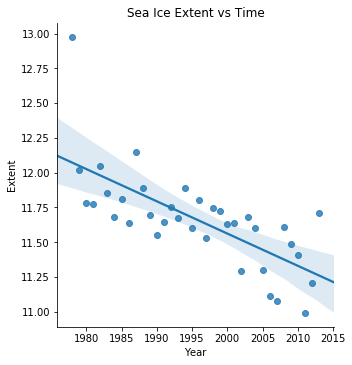

In [17]:
# Linear regression extent vs year
sns.lmplot(x='Year', y='Extent', data=dfcss) #plots data in a regression model
ax = plt.gca()  #gets argument names for axis
ax.set_title("Sea Ice Extent vs Time") #sets title

# Correlações

In [3]:
def heatmap(df):
    fig, axes = plt.subplots(figsize=(10, 7))
    corr = df.corr()            # Calculate correlation of param

    mask = np.zeros_like(corr)   # Create a array of zeros with the same shape as the df provided
    # print(mask)

    mask[np.triu_indices_from(mask)] = True    # set the index of the upper triangle of the array to True (1)
    # print(mask)

    with sns.axes_style("white"):
        sns.heatmap(corr, linewidths=1, 
                    annot=True, 
                    mask=mask, 
                    vmax=.3, 
                    square=True)  # mask: data will not be
                                                                                           # shown in cells where mask
                                                                                           #  is True

    axes.set_title('Heatmap: Condições ambientais')
    plt.yticks(rotation=0, fontsize=14)
    plt.xticks(rotation=90, fontsize=14)
    plt.show()
    
# Function call
heatmap(dfcss)

NameError: name 'dfcss' is not defined